# An example workflow of the QAOA package

This notebook walks through a simple example workflow, from start to finish. More elaborate examples are provided in other notebooks.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# import the neccesary pyquil modules
from pyquil.api import local_qvm, WavefunctionSimulator
from pyquil.paulis import PauliSum, PauliTerm

# import the QAOAParameters that we want to demo
from forest_qaoa.qaoa.parameters import (AbstractParams, StandardParams, ExtendedParams,
                                         QAOAParameterIterator)

# import VQE and cost function modules
from forest_qaoa.qaoa.cost_function import QAOACostFunctionOnQVM, QAOACostFunctionOnWFSim

## Set up the problem hyperparameters

We start by setting up the Hamiltonian encoding the cost function we wish to minimise, as well as the timesteps to run QAOA. We do so by first using the `AbstractParams` class, however we could just as easily set up any specific parametrisation directly -- see the notebook `QAOAParameterDemo.ipynb` for more details. 

In [2]:
hamiltonian = PauliSum.from_compact_str("0.7*Z0*Z1 + 1.2*Z0*Z2 + (-0.5)*Z0")
print("hamiltonian =", hamiltonian)

timesteps = 2
abstract_params = AbstractParams([hamiltonian,timesteps])
print(abstract_params)

hamiltonian = (0.7+0j)*Z0*Z1 + (1.2+0j)*Z0*Z2 + (-0.5+0j)*Z0
Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	single_qubit_coeffs: [-0.5]
	qubits_pairs: [[0, 1], [0, 2]]
	pair_qubit_coeffs: [0.7 1.2]
	n_steps: 2



## Specfify the variable parameters and create corresponding `QAOAParameters` object

Here we will set up `StandardParameters` - this corresponds to the parametrisation of the original QAOA paper by Farhi et al, where the mixer and cost Hamiltonian each have one angle per timestep (giving a total of 2p parameters to optimise over).

In [4]:
# Specify some angles
betas          = [0.1, 0.6]
gammas = [0.4, 0.5]
parameters = (betas, gammas)

standard_params = StandardParams.from_AbstractParameters(abstract_params, parameters)
print(standard_params)

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	qubits_pairs: [[0, 1], [0, 2]]
Parameters:
	betas: [0.1 0.6]
	gammas: [0.4 0.5]



## Set up the cost function and running the optimiser

Let's work on the wavefunction simulator (note this requires opening the qvm in separate terminal windows as explained in the Forest documentation). We create the `cost_function` object, with all the necessary inputs.

*Notes:*
 - To start the Wavefunction simulator open a terminal and type `qvm -S`. If you installed the Forest SDK, this should start the Quantum Virtual Machine in the background
 - In the Notebook `VQEDemo.ipynb` we go into more detail, what the parameter `noisy` and `enable_logging` mean and how to use them.

In [6]:
# Set up the WavefunctionSimulator
sim = WavefunctionSimulator()

In [11]:
# set up the cost function
cost_function = QAOACostFunctionOnWFSim(hamiltonian,
                                        params=standard_params,
                                        sim=sim,
                                        scalar_cost_function=True, # See VQEDemo.ipynb for more details
                                        nshots=1,                  # irrelevant, if noisy=False
                                        noisy=False,               # See VQEDemo.ipynb for more details
                                        enable_logging=False)

# and optimize the parameters
res = minimize(cost_function, standard_params.raw(), tol=1e-3,
                      options={"maxiter": 500})
res

      fun: -1.3144997100429072
 hess_inv: array([[ 0.85661361, -0.13446316, -0.56426646,  1.00665206],
       [-0.13446316,  0.26647175,  0.44469378, -0.37759762],
       [-0.56426646,  0.44469378,  1.05583137, -1.12639425],
       [ 1.00665206, -0.37759762, -1.12639425,  1.68879291]])
      jac: array([-0.00098708,  0.00072014, -0.00018305,  0.00044395])
  message: 'Optimization terminated successfully.'
     nfev: 54
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([ 1.25728871,  0.2796165 , -0.2139891 ,  0.60956304])

We can check this against the value we should get, by finding the lowest eigenvalue of `hamiltonian`.

In [13]:
ham_matrix = hamiltonian.matrix()
eigs = np.linalg.eigvalsh(ham_matrix)
min(eigs)

-2.4

Clearly we have not found the ground state energy. We can try increasing the number of timesteps:

In [14]:
betas          = [0.1, 0.6, 0.8]
gammas_singles = [0.4, 0.5, 0.6]
gammas_pairs   = [0.1, 0.3, 0.5]
parameters = (betas, gammas_singles, gammas_pairs)

standard_params_p3 = StandardParams([hamiltonian,3],parameters)

In [20]:
sim = WavefunctionSimulator()

cost_function = QAOACostFunctionOnWFSim(hamiltonian,
                                        params=standard_params_p3,
                                        sim=sim,
                                        return_standard_deviation=True,
                                        noisy=False)

res = minimize(cost_function, standard_params_p3.raw(), tol=1e-3,
                      options={"maxiter": 500})
res

      fun: -1.9556233482538181
 hess_inv: array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])
      jac: array([ 2.63571739e-04,  1.73628330e-04, -1.90958381e-04,  2.13712454e-04,
       -1.98736787e-04,  8.58604908e-05])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.64276828, 0.4335698 , 0.24545526, 0.39828896, 0.7586378 ,
       0.81549841])

This is better, but still not the actual ground state. Since we don't seem to be doing very well with `StandardParams`, let's try the `ExtendedParams` parametrisation instead.

In [22]:
extended_params_p3 = ExtendedParams.linear_ramp_from_hamiltonian(hamiltonian, n_steps=3)

cost_function = QAOACostFunctionOnWFSim(hamiltonian,
                                        params=extended_params_p3,
                                        sim=sim,
                                        scalar_cost_function=True,
                                        nshots=1,
                                        noisy=False)

res = minimize(cost_function, extended_params_p3.raw(), tol=1e-3,
                      options={"maxiter": 500})
res

      fun: -2.3999999966878813
 hess_inv: array([[ 4.88041399e-01, -2.95839411e-02, -2.06403884e-01,
        -3.08576479e-02, -7.12695629e-02,  8.11671680e-03,
        -1.32082990e-02, -1.11938411e-02,  5.17395120e-02,
         6.36187622e-03,  1.95987860e-02, -1.21002917e-02,
        -2.99687505e-02, -3.62049762e-03,  6.06445361e-02,
        -3.18902095e-02, -4.24891408e-02, -7.94992359e-02],
       [-2.95839411e-02,  9.98159530e-01,  4.35282971e-02,
         1.64850819e-02,  7.20151884e-02, -1.24121883e-02,
        -2.46762517e-02,  6.60636540e-02, -1.21868447e-02,
         1.23146550e-01,  5.60762057e-03,  9.15314167e-03,
         1.60415128e-02, -1.32240067e-02,  4.01743213e-03,
         2.10469173e-02,  3.16083158e-03,  5.14813294e-02],
       [-2.06403884e-01,  4.35282971e-02,  9.74016746e-01,
         1.06527845e-01,  5.29073013e-02,  5.04064784e-02,
         3.08809735e-02,  8.32395894e-02,  3.27140233e-02,
         3.93854696e-01,  2.59950279e-02,  1.52357938e-02,
        -7.5

Bingo! The result attribute `x` is a list of the optimal circuit parameters that have been found. We can disentangle this into the `betas` and `gammas` of our QAOA parameterisation by using the `update_from_raw()` method:

In [23]:
extended_params_p3.update_from_raw(res['x'])
extended_params_p3

Hyperparameters:
	register: [0, 1, 2]
	qubits_singles: [0]
	qubits_pairs: [[0, 1], [0, 2]]
Parameters:
	betas: [[ 7.85378501e-01  5.54396052e-01  7.43442653e-01], [-8.99481436e-07  3.69031510e-01  8.20260928e-01], [ 2.46724659e-06  5.18760787e-01  8.97721055e-02]]
	gammas_singles: [[ 1.57083131], [ 0.18327377], [-0.19606371]]
	gammas_pairs: [[-1.95481070e-05 -1.13875804e-05], [ 6.11713001e-01  5.85523260e-01], [ 6.17534031e-01  8.19147812e-01]]

Now that we have the optimal angles, we can prepare the corresponding state and sample from it to obtain the most probable bitstring. Or we cheat a little bit, and have a look at the wavefunction directly. We are running on the wavefunction simulator after all! To do this, we use the `get_wavefunction` method of the `cost_function`.

In [29]:
opt_wfn = cost_function.get_wavefunction(res.x)
print(opt_wfn)

(-4e-10+3e-10j)|000> + (2.63046e-05+1.9491e-06j)|001> + (-1.01837e-05-1.99891e-05j)|010> + (9.1521e-06-1.02149e-05j)|011> + (1.36931e-05+3.9468e-06j)|100> + (-1.17953e-05-6.8093e-06j)|101> + (-0.7070830918+0.7071304685j)|110> + (-1.7157e-06-2.4137e-06j)|111>


In [30]:
probs = opt_wfn.probabilities()
probs

array([2.02738011e-19, 6.95731400e-10, 5.03270071e-10, 1.88104540e-10,
       2.03079013e-10, 1.85494717e-10, 9.99999998e-01, 8.76951866e-12])

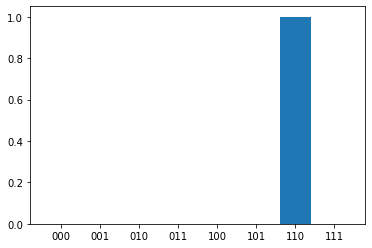

In [31]:
labels = ["{0:03b}".format(i) for i in range(8)]
plt.bar(range(8),probs)
plt.xticks(range(8), labels)

The QAOA has determined that the bitstring 110 (6 in decimal) is the minimum energy solution. Let's check this is consistent with the real answer:

In [32]:
np.linalg.eig(ham_matrix)

(array([ 1.4+0.j, -1.4+0.j,  0. +0.j,  0. +0.j, -1. +0.j,  1. +0.j,
        -2.4+0.j,  2.4+0.j]),
 array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]]))

The lowest energy solution does indeed correspond to the eigenvector $(0,0,0,0,0,0,1,0)$, i.e. the $|001\rangle$ component.

Interestingly, the soltution was found with a very high probability (see the values of `probs` above). The second largest component is the $|001\rangle$ component, although its probability is four orders of magnitude smaller. It is not coincidental that this state is related to the ground state $|110\rangle$ by a bit flip on each qubit. Suppose we return to the original Hamiltonian, but instead we remove the single-qubit bias term on qubit 0. Let's run the entire computation again and see what we get.

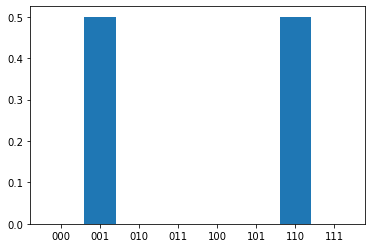

In [33]:
hamiltonian = PauliSum.from_compact_str("0.7*Z0*Z1 + 1.2*Z0*Z2")
n_steps = 2

no_bias_params = ExtendedParams.linear_ramp_from_hamiltonian(hamiltonian,n_steps)

cost_function = QAOACostFunctionOnWFSim(hamiltonian,
                                        params=no_bias_params,
                                        sim=sim,
                                        nshots=1,
                                        noisy=False)

res = minimize(cost_function, no_bias_params.raw(), tol=1e-3, options={"maxiter":500})

opt_wfn = cost_function.get_wavefunction(res.x)
probs = opt_wfn.probabilities()

labels = ["{0:03b}".format(i) for i in range(8)]
plt.bar(range(8),probs)
plt.xticks(range(8), labels)

Now the probabilities are completely symmetric under a bit flip on all qubits - there is no bias term in the Hamiltonian to force a given qubit into state $|0\rangle$ or $|1\rangle$, and the eigenspectrum of the cost function Hamiltonian is "doubly degenerate", i.e. the energy eigenstates fall into pairs, where the corresponding eigenstates are related to one another by a bit flip on all qubits. 